Pokemon classifier
==================

Steps:
- [0. Data exploration](0_Exploration.ipynb)
- [1. Detect human faces](1_Detect_Human.ipynb)
- [2. Detect Pokémon](2_Detect_Pokemon.ipynb)
- [3. Pokemon classifier](3_Pokemon_classifier.ipynb)
- [4. Predictions](4_Predict.ipynb)

# Datasets

- [Pokemon Generation One](https://www.kaggle.com/lantian773030/pokemonclassificationone). 
  This dataset will be used to train and evaluate a Pokémon detector and a classifier of Pokémon species.
- [Labeled Faces in the Wild Home](http://vis-www.cs.umass.edu/lfw/lfw.tgz).
  This dataset will be used to evaluate a human face detector.
- [CIFAR-100](https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz).
  This dataset will be used to train the Pokémon detector, providing examples not representing Pokémon.

# Data exploration

In [1]:
import copy
import time
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import optim, nn
import torch.optim.lr_scheduler as lr_scheduler
import torchvision
from torchvision import models, transforms
from torch.utils.data import RandomSampler

In [2]:
import utils

In [3]:
# load filenames for human and dog images
human_files = np.array(glob("../data/lfw/*/*"))
pokemon_files = np.array(glob("../data/Pokemon/*/*"))
cifar100 = torchvision.datasets.CIFAR100(root='../data/', download=True)

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total pokemon images.' % len(pokemon_files))
print('There are %d total CIFAR images.' % len(cifar100))

Files already downloaded and verified
There are 13233 total human images.
There are 6837 total pokemon images.
There are 50000 total CIFAR images.


## Human dataset exploration

In [4]:
df_human = utils.load_dataset('../data/lfw')
df_human

,target,label,filename
0,5360,Tim_Curry,../data/lfw/Tim_Curry/Tim_Curry_0001.jpg
1,3434,Mahmoud_Abbas,../data/lfw/Mahmoud_Abbas/Mahmoud_Abbas_0023.jpg
2,3807,Michel_Charles_Chretien,../data/lfw/Michel_Charles_Chretien/Michel_Cha...
3,26,Abid_Hamid_Mahmud_Al-Tikriti,../data/lfw/Abid_Hamid_Mahmud_Al-Tikriti/Abid_...
4,3957,Mona_Locke,../data/lfw/Mona_Locke/Mona_Locke_0001.jpg
...,...,...,...
13228,5252,Tang_Jiaxuan,../data/lfw/Tang_Jiaxuan/Tang_Jiaxuan_0010.jpg
13229,2122,Hestrie_Cloette,../data/lfw/Hestrie_Cloette/Hestrie_Cloette_00...
13230,2175,Hugo_Chavez,../data/lfw/Hugo_Chavez/Hugo_Chavez_0069.jpg
13231,373,Ariel_Sharon,../data/lfw/Ariel_Sharon/Ariel_Sharon_0045.jpg


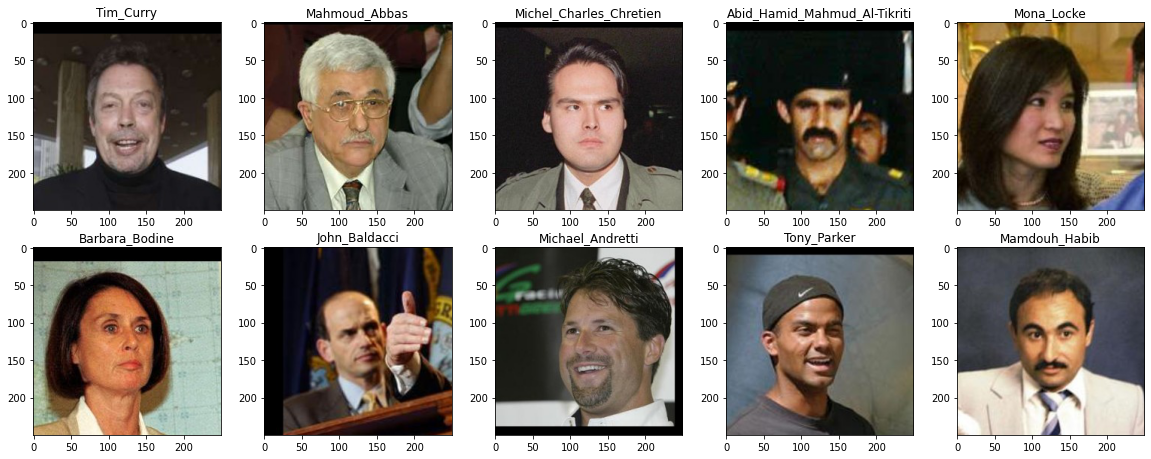

In [5]:
utils.show_first_img(df_human)

## Pokémon dataset exploration

In [6]:
df_pokemon = utils.load_dataset('../data/Pokemon')
# Removes SVG files
df_pokemon = df_pokemon[df_pokemon.apply(lambda x: not x.filename.endswith('.svg'), axis=1)]
df_pokemon

,target,label,filename
0,74,Magikarp,../data/Pokemon/Magikarp/59c928d4b8fc40f48d4c5...
1,84,Moltres,../data/Pokemon/Moltres/c026fa5056c84c02b8bd93...
2,11,Butterfree,../data/Pokemon/Butterfree/59a63a02e61a4945a06...
3,145,Weepinbell,../data/Pokemon/Weepinbell/39098299faa74451ae1...
4,149,Zubat,../data/Pokemon/Zubat/78bf5e565dad458dbc9926e1...
...,...,...,...
6832,86,Muk,../data/Pokemon/Muk/46549609739e41c191ec1fba66...
6833,117,Sandshrew,../data/Pokemon/Sandshrew/50fc676b907246868bad...
6834,118,Sandslash,../data/Pokemon/Sandslash/11d64851bc1e4c9da97b...
6835,121,Seaking,../data/Pokemon/Seaking/55316aba966146e5aae002...


#### Number of classes

In [7]:
print('Number of Pokémon species:', len(df_pokemon["label"].unique()))

Number of Pokémon species: 150


We miss 1 Pokémon in our dataset (Gen 1 is about 151 Pokémon), but we will ignore this issue

#### Show samples

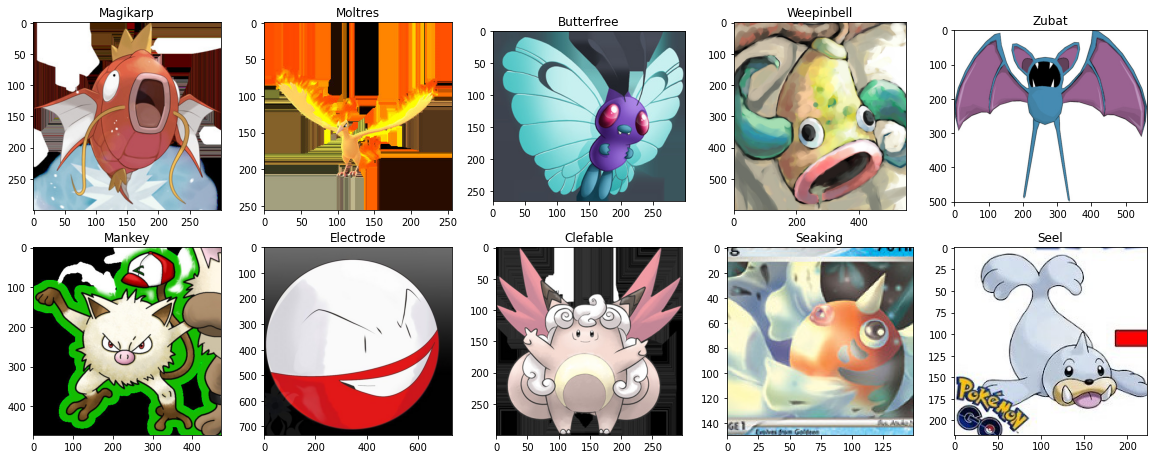

In [8]:
utils.show_first_img(df_pokemon)

## Repartition of images per class

std = 6.741387744732698


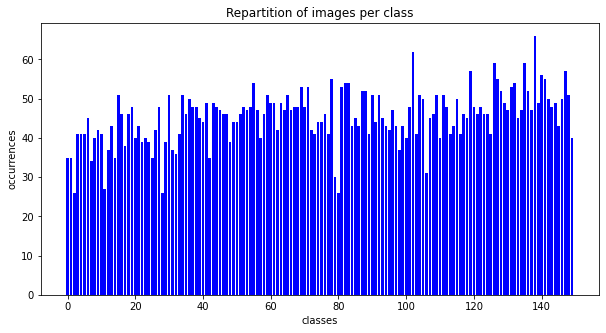

In [12]:
counts = df_pokemon.groupby('target').size().reset_index(name="Counts")
plt.figure(figsize=(10,5))
plt.xlabel('classes')
plt.ylabel('occurrences')
plt.title('Repartition of images per class')
plt.bar(range(len(counts)), counts['Counts'], color = 'blue')
print('std =', df_pokemon.groupby('target').size().std())

Standard deviation is about 7.<br>
The repartition between classes is not perfect, but it will be ok.


## CIFAR100 dataset exploration

In [10]:
transform, std_nums, mean_nums = utils.torch_transformations()

cifar100 = torchvision.datasets.CIFAR100(root='data/', download=True, transform=transform['test'])

Files already downloaded and verified


In [11]:
df = utils.load_dataset_cifar(cifar100)
df

,target,label
0,19,cattle
1,29,dinosaur
2,0,apple
3,11,boy
4,1,aquarium_fish
...,...,...
49995,80,squirrel
49996,7,beetle
49997,3,bear
49998,7,beetle


In [12]:
print('Number of classes:', len(df["label"].unique()))

Number of classes: 100


In [13]:
cifar_loader = torch.utils.data.DataLoader(cifar100, batch_size=8,
                                          shuffle=True, num_workers=2)

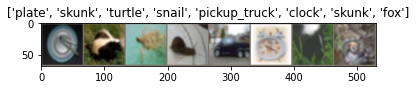

In [14]:
inputs, classes = next(iter(cifar_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

utils.imshow_tensor(out, std_nums, mean_nums, title=[cifar100.classes[x] for x in classes])

std = 0.0


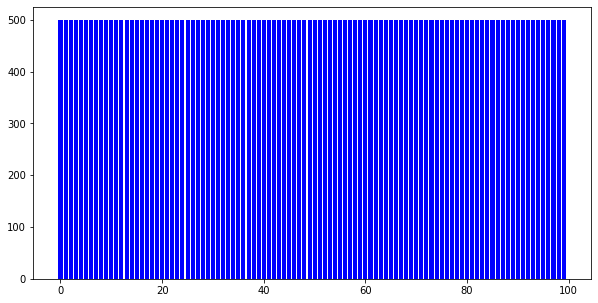

In [15]:
counts = df.groupby('target').size().reset_index(name="Counts")
plt.figure(figsize=(10,5))
plt.bar(range(len(counts)), counts['Counts'], color = 'blue')
print('std =', df.groupby('target').size().std())

Standard deviation is 0.<br>
The repartition between classes is perfect.

With this dataset we have many exemples of obects, animal, plants, vehicules, etc..<br>
We will use it to detect if an input image is a Pokemon or something else.